### Detection of fraudulent transactions in a credit card dataset.

##### Import Libraries

In [ ]:
import shap
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import mlflow.sklearn
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from lime.lime_tabular import LimeTabularExplainer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
mlflow.sklearn.autolog()

##### Load data

In [ ]:
df = pd.read_csv('cleaned_data/Preprocessed_Creditcard_Data.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,time_in_days,Amount_scaled
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.000000,0.244200
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.000000,-0.342584
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0.000012,1.158900
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.000012,0.139886
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0.000023,-0.073813


##### Visual class distribution

Class
0    283253
1       473
Name: count, dtype: int64


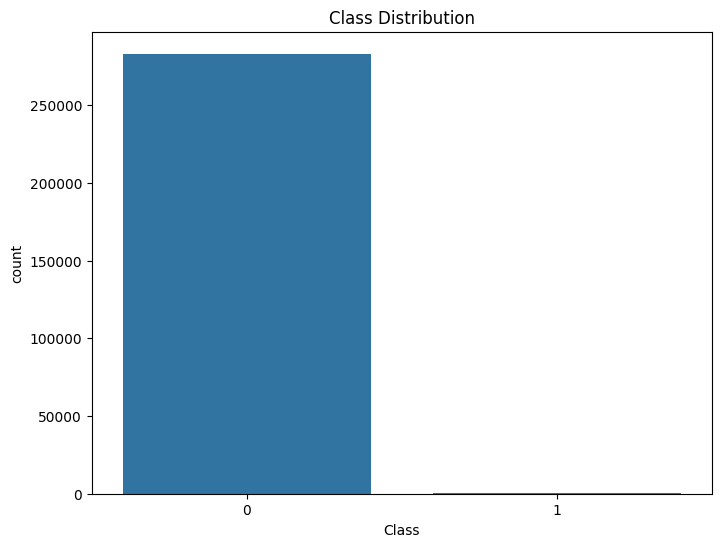

In [4]:
# Visualize Class distribution
class_counts = df['Class'].value_counts()
print(class_counts)

# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Class', data=df)
plt.title('Class Distribution')
plt.show()

##### Feature-Target Separation and Data Splitting

In [5]:
X = df.drop('Class', axis=1)
y = df['Class']

##### Using SMOTE (Synthetic Minority Over-sampling Technique) to generate synthetic data

In [22]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X_train = X_resampled
y_train = y_resampled

class_counts = y_train.value_counts()
print(class_counts)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

Class
0    283253
1    283253
Name: count, dtype: int64


In [23]:
X_train.columns.tolist() 

['Time',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'Amount',
 'time_in_days',
 'Amount_scaled']

##### Scaling the Features

In [7]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Tracking with MLflow

In [ ]:
import os 
import joblib
# saving the models
save_folder = 'saved_models'
os.makedirs(save_folder, exist_ok=True) 

# Function to save scikit-learn models
def save_sklearn_model(model, model_name):
    save_path = os.path.join(save_folder, f'{model_name}.joblib')
    joblib.dump(model, save_path)
    print(f'{model_name} saved at {save_path}')


In [10]:
# Function to log experiments with MLflow
def log_experiment(model_name, model, X_train, X_test, y_train, y_test, params=None):
    with mlflow.start_run(run_name=model_name):
        # Fit the model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        
        # Log parameters if provided
        if params:
            for key, value in params.items():
                mlflow.log_param(key, value)
        
        # Log metrics
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1_score", f1)
        
        # Log the model
        mlflow.sklearn.log_model(model, model_name)
        
        print(f"Model: {model_name}")
        print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1}")
        save_sklearn_model(model, model_name)
        print('model saved')

##### Training a Logistic Regression Model

In [ ]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_experiment("Logistic Regression", log_reg, X_train, X_test, y_train, y_test, 
               params={"max_iter": 1000})

##### Training a Random forest model

In [ ]:
# Random Forest
rand_forest = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
log_experiment("Random Forest", rand_forest, X_train, X_test, y_train, y_test, 
               params={"n_estimators": 100, "max_depth": 10})


##### Training a Gradient Boosting Model

In [ ]:
# Gradient Boosting
grad_boost = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
log_experiment("Gradient Boosting", grad_boost, X_train, X_test, y_train, y_test, 
               params={"n_estimators": 100, "learning_rate": 0.1})

##### Training a DecisionTree Model

In [ ]:
# Decision Tree
dec_tree = DecisionTreeClassifier(max_depth=5, random_state=42)
log_experiment("Decision Tree", dec_tree, X_train, X_test, y_train, y_test, 
               params={"max_depth": 5})

### Model Explanability using shap

In [20]:
import shap
import mlflow
import joblib
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def log_experiment_with_shap(model_name, model, X_train, X_test, y_train, y_test, params=None):
    # Ensure X_train and X_test are DataFrames to access feature names
    if not isinstance(X_train, pd.DataFrame):
        raise ValueError("X_train must be a pandas DataFrame.")
    if not isinstance(X_test, pd.DataFrame):
        raise ValueError("X_test must be a pandas DataFrame.")

    with mlflow.start_run(run_name=model_name):
        
        # SHAP Explanation for Logistic Regression using KernelExplainer
        if model_name == "Logistic Regression":
            # Use KernelExplainer for Logistic Regression
            background = shap.sample(X_train, 100)  # Sampling a smaller set for the background
            explainer = shap.KernelExplainer(model.predict, background)
            
            # Subsample the test set to handle large data (optional for memory efficiency)
            X_test_sample = X_test.sample(n=100, random_state=42)

            # Get SHAP values
            shap_values = explainer.shap_values(X_test_sample)
            
            # Summary plot with feature names
            shap.summary_plot(shap_values, X_test_sample, plot_type="bar", feature_names=X_test.columns)

        elif model_name in ["Gradient Boosting", "Random Forest", "Decision Tree"]:
            explainer = shap.TreeExplainer(model)
            shap_values = explainer.shap_values(X_test)
            
            # Summary plot with feature names
            shap.summary_plot(shap_values, X_test, max_display=32, feature_names=X_test.columns)

        # Logging metrics
        y_pred = model.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred)
        rec = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)

        # Log parameters and metrics to MLflow
        if params:
            mlflow.log_params(params)
        mlflow.log_metric("accuracy", acc)
        mlflow.log_metric("precision", prec)
        mlflow.log_metric("recall", rec)
        mlflow.log_metric("f1_score", f1)
        
        print(f"Model: {model_name} | Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1 Score: {f1:.4f}")

##### Logistic regression

In [ ]:
model_name = "Logistic Regression"
model_path = "saved_models/Logistic Regression.joblib"  
model = joblib.load(model_path)

log_experiment_with_shap(
    model_name=model_name,
    model=model,
    X_train=X_train,         
    X_test=X_test,          
    y_train=y_train,         
    y_test=y_test,          
    params={"C": 1.0}        
)

##### Decision Tree

In [ ]:
model_name = "Decision Tree"
model_path = "saved_models/Decision Tree.joblib"  
model = joblib.load(model_path)

log_experiment_with_shap(
    model_name=model_name,
    model=model,
    X_train=X_train,         
    X_test=X_test,          
    y_train=y_train,         
    y_test=y_test,          
    params={"max_depth": 10}       
)

##### RandomForest

In [ ]:
model_name = "Random Forest"
model_path = "saved_models/Random Forest.joblib"  
model = joblib.load(model_path)

log_experiment_with_shap(
    model_name=model_name,
    model=model,
    X_train=X_train,         
    X_test=X_test,          
    y_train=y_train,         
    y_test=y_test,          
    params={"n_estimators": 100}
)

##### GradientBoosting

In [ ]:
model_name = "Gradient Boosting"
model_path = "saved_models/Gradient Boosting.joblib"  
model = joblib.load(model_path)

log_experiment_with_shap(
    model_name=model_name,
    model=model,
    X_train=X_train,         
    X_test=X_test,          
    y_train=y_train,         
    y_test=y_test,          
    params={"n_estimators": 100, "learning_rate": 0.1}
)

### Model Explanability using Lime

In [31]:
import mlflow
import mlflow.sklearn
from lime.lime_tabular import LimeTabularExplainer
import joblib
import numpy as np
import pandas as pd

# Disable autologging for scikit-learn to avoid conflicts
mlflow.sklearn.autolog(disable=True)

def log_experiment_with_lime(model_name, model_path, X_train, X_test, y_train, y_test, sample_index=0, params=None, show_in_notebook=True):
    # Load the pre-trained model
    model = joblib.load(model_path)
    
    # Ensure X_train and X_test are handled consistently as arrays
    if isinstance(X_train, pd.DataFrame):
        feature_names = X_train.columns.tolist()  # Get actual feature names from X_train DataFrame
        X_train_values = X_train.values
    else:
        feature_names = [f'Feature_{i}' for i in range(model.n_features_in_)]  # Placeholder names
        X_train_values = X_train

    # Use all features from X_test for explanations
    if isinstance(X_test, pd.DataFrame):
        X_test_values = X_test.values  # Get all features
        instance = X_test.iloc[sample_index].values  # Use specified sample_index
    else:
        X_test_values = X_test  # Get all features as array
        instance = X_test[sample_index]  # Use specified sample_index
    
    # Start an MLflow run
    with mlflow.start_run(run_name=model_name):
        
        # Log model parameters if provided
        if params is not None:
            mlflow.log_params(params)
        
        # Log the trained model with an input example
        input_example = np.array([X_train_values[0]])  # Use first row as an example
        mlflow.sklearn.log_model(model, model_name, input_example=input_example)
        
        # Initialize the LimeTabularExplainer with actual feature names
        explainer = LimeTabularExplainer(
            training_data=X_train_values,  # Use all training features
            mode='classification', 
            feature_names=feature_names,  # Use all feature names
            class_names=np.unique(y_train).tolist(), 
            discretize_continuous=True
        )
        
        # Generate explanation for the specified instance in X_test
        exp = explainer.explain_instance(
            instance,
            model.predict_proba,
            num_features=10  # Show all features
        )
        
        # Plot the explanation using Matplotlib
        plt.figure(figsize=(10, 5))
        exp.as_pyplot_figure()
        plt.title(f'LIME Explanation for Sample {sample_index}')
        plt.show()

        # Print some information
        print(f"Model: {model_name}")


# Ensure the sample_index you want to test is consistent across different models
sample_index = 0  # Change this index as needed for different instances

##### Logistic Regression

<Figure size 1000x500 with 0 Axes>

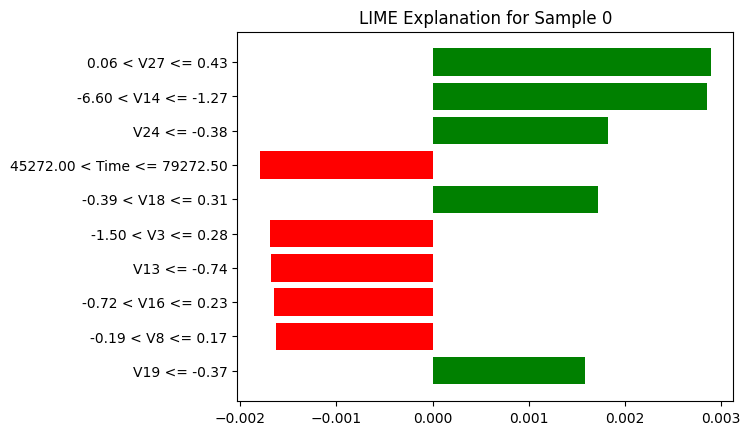

Model: Logistic Regression


In [ ]:
# Load your saved Logistic Regression model
params={"max_iter": 100}

log_experiment_with_lime(
    model_name="Logistic Regression",
    model_path='saved_models/Logistic Regression.joblib',
    X_train=X_train,         
    X_test=X_test,           
    y_train=y_train,         
    y_test=y_test,
    sample_index=sample_index,           
    params=params,           
    show_in_notebook=True     
)

##### Decision Tree

<Figure size 1000x500 with 0 Axes>

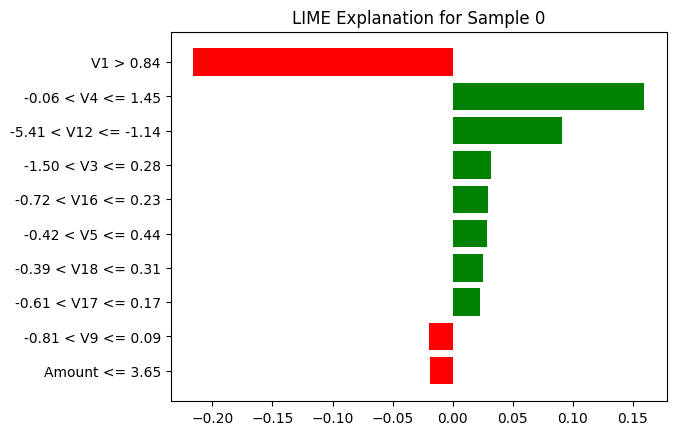

Model: Decision Tree


In [ ]:
# Load your saved Decision Tree model
params={"max_depth": 5}

log_experiment_with_lime(
    model_name="Decision Tree",
    model_path='saved_models/Decision Tree.joblib',
    X_train=X_train,         
    X_test=X_test,           
    y_train=y_train,         
    y_test=y_test,
    sample_index=sample_index,           
    params=params,           
    show_in_notebook=True    
)

##### Gradient Boosting

<Figure size 1000x500 with 0 Axes>

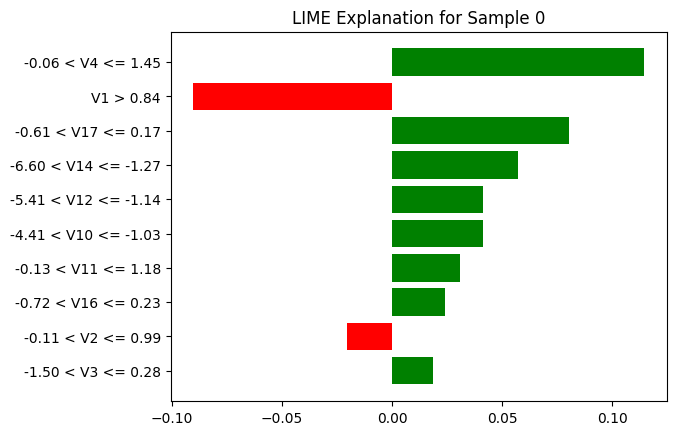

Model: Gradient_Boosting


In [ ]:
# Load your saved Gradient boosting model
params={"n_estimators": 100, "learning_rate": 0.1}

log_experiment_with_lime(
    model_name="Gradient_Boosting",
    model_path='saved_models/Gradient Boosting.joblib',
    X_train=X_train,         
    X_test=X_test,           
    y_train=y_train,         
    y_test=y_test,  
    sample_index=sample_index,         
    params=params,           
    show_in_notebook=True    
)

##### Random forest

<Figure size 1000x500 with 0 Axes>

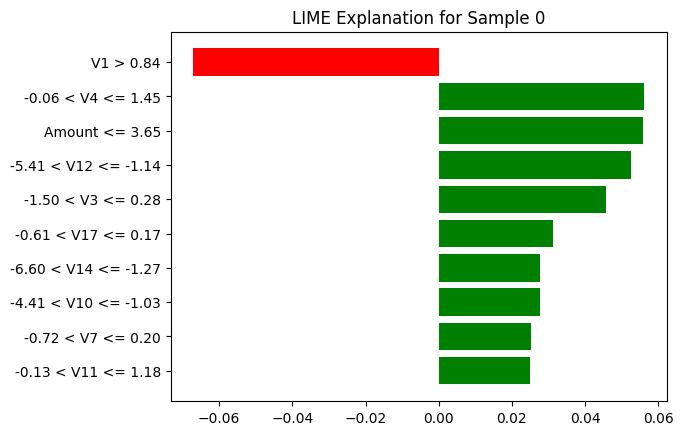

Model: RandomForestClassifier


In [ ]:
params = {"n_estimators": 100, "max_depth": 10}

log_experiment_with_lime(
    model_name="RandomForestClassifier",
    model_path="saved_models/Random Forest.joblib",
    X_train=X_train,        
    X_test=X_test,          
    y_train=y_train,        
    y_test=y_test,  
    sample_index=sample_index,         
    params=params,           
    show_in_notebook=True    
)